<a href="https://colab.research.google.com/github/trentfridey/qosf-screening/blob/master/Task1FromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import autograd.numpy as np
from autograd import grad
from functools import reduce
from autograd.misc.optimizers import adam
import matplotlib.pyplot as plt

In [44]:
def epsilon(n_layers):

  print("Number of Layers: {}".format(n_layers))
  # Operators

  sx = np.array([[0,1],[1,0]])
  sy = np.array([[0,-1j],[1j,0]])
  sz = np.array([[1,0],[0,-1]])

  p0 = np.array([[1,0],[0,0]])
  p1 = np.array([[0,0],[0,1]])

  # Gates

  def Rx(theta):
    mat = -1j*theta*0.5*sx
    return np.exp(mat)

  def Ry(theta):
    mat = -1j*theta*0.5*sy
    return np.exp(mat)

  def Rz(theta):
    return np.array([[np.exp(-0.5j*theta), 0], [0, np.exp(0.5j*theta)]])

  def CZ(i,j):
    ops0 = [np.eye(2) for i in range(4)]
    ops1 = [np.eye(2) for i in range(4)]
    ops0[i] = p0
    ops1[i] = p1
    ops1[j] = sz
    cz0 = reduce(lambda res, op: np.kron(res, op), ops0)
    cz1 = reduce(lambda res, op: np.kron(res, op), ops1)
    return cz0 + cz1

  # Blocks

  def odd(thetas):
    rots = [Rx(theta) for theta in thetas[1:]]
    rot = Rx(thetas[0])
    for r in rots:
      rot = np.kron(rot,r)
    return rot

  def even(thetas):
    rots = [Rz(theta) for theta in thetas[1:]]
    rot = Rx(thetas[0])
    for r in rots:
      rot = np.kron(rot, r)
    CZs = np.eye(16)
    for i in range(3):
      for j in range(i+1, 4):
        CZs = CZs @ CZ(i,j)
    return rot @ CZs

  # Layer

  def layer(thetas):
    return odd(thetas[0:4]) @ even(thetas[4:8])

  # Circuit

  def circuit(thetas):
    circuit = np.eye(16)
    for l in range(n_layers):
      circuit = circuit @ layer(thetas[8*l:8*(l+1)])
    return circuit

  # Objective

  target = np.array([0 for i in range(0,15)] + [1])

  def objective(thetas,iter):
    start_state = np.array([1] + [0 for i in range(1,16)])
    circ = circuit(thetas)
    return np.sum(np.abs(np.dot(circ, start_state) - target))

  # Optimization

  grad_obj = grad(objective)

  init_thetas = np.random.normal(0, np.pi, 8*n_layers)
  step_size = 0.1
  num_iters = 200 + 20*n_layers

  def handle_step(params, iter, grad):
    if iter % 20 == 0:
      print("Cost after {} steps is {}".format(iter, objective(params, iter)))

  optimized_thetas = adam(grad_obj, init_thetas, step_size=step_size, num_iters=num_iters, callback=handle_step)

  epsilon = objective(optimized_thetas,0)
  return epsilon

In [54]:
def gen_data_points():
  return [epsilon(n_layers) for n_layers in range(1,11)]

e_data = gen_data_points()

Number of Layers: 1
Cost after 0 steps is 24.50183288506046
Cost after 20 steps is 12.846670856278838
Cost after 40 steps is 2.4584165021441953
Cost after 60 steps is 1.8332119465465073
Cost after 80 steps is 1.2043982880255486
Cost after 100 steps is 1.2670976210876472
Cost after 120 steps is 1.0453749066903284
Cost after 140 steps is 1.1223287067274712
Cost after 160 steps is 1.00786283210248
Cost after 180 steps is 1.2730282073473111
Cost after 200 steps is 1.1819394937333525
Number of Layers: 2
Cost after 0 steps is 72.78300395965724
Cost after 20 steps is 3.1060014160871963
Cost after 40 steps is 1.212973518742756
Cost after 60 steps is 1.0489037310937903
Cost after 80 steps is 1.0019842056076604
Cost after 100 steps is 1.001121482703758
Cost after 120 steps is 1.000149633939153
Cost after 140 steps is 1.0000156678297165
Cost after 160 steps is 1.0000019879629811
Cost after 180 steps is 1.0000008435025047
Cost after 200 steps is 1.0000001708063304
Cost after 220 steps is 1.0000002

Text(0, 0.5, 'Distance from target $|\\phi\\rangle$')

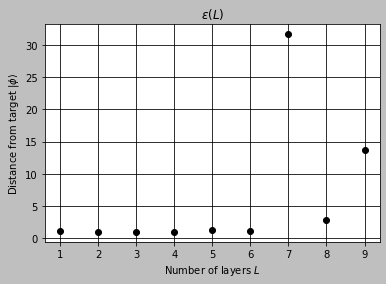

In [63]:
plt.style.use("grayscale")
fig, ax = plt.subplots()
ax.grid()
ax.plot(np.array([i for i in range(1,10)]), e_data[0:9], marker="o", linestyle="")
ax.set_title(r'$\epsilon(L)$')
ax.set_xlabel(r'Number of layers $L$')
ax.set_ylabel(r'Distance from target $|\phi\rangle$')